# FREDから経済データを取得+ベイズ時系列解析

In [1]:
using Distributed
addprocs(3)

@everywhere using Mamba

In [2]:
using DataFrames
using Dates
using DotEnv
using HTTP
import ForneyLab.dot2svg
using JSON
using Plots
using Printf

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


## 経済データの取得

In [3]:
DotEnv.config();

In [4]:
timeseries_url = @sprintf(
    "https://api.stlouisfed.org/fred/series/observations?series_id=%s&api_key=%s&file_type=json",
    "IPG2211A2N",
    ENV["FRED_API_KEY"])
r = HTTP.get(timeseries_url)

HTTP.Messages.Response:
"""
HTTP/1.1 200 OK
Content-Type: application/json; charset=UTF-8
Server: Apache
Last-Modified: Wed, 27 Mar 2019 16:21:04 GMT
Expires: Sat, 30 Mar 2019 18:27:55 GMT
x-rate-limit-limit: 120
x-rate-limit-remaining: 120
Date: Sat, 30 Mar 2019 18:27:55 GMT
Transfer-Encoding: chunked
Connection: keep-alive, Transfer-Encoding

{"realtime_start":"2019-03-30","realtime_end":"2019-03-30","observation_start":"1600-01-01","observation_end":"9999-12-31","units":"lin","output_type":1,"file_type":"json","order_by":"observation_date","sort_order":"asc","count":962,"offset":0,"limit":100000,"observations":[{"realtime_start":"2019-03-30","realtime_end":"2019-03-30","date":"1939-01-01","value":"3.3842"},{"realtime_start":"2019-03-30","realtime_end":"2019-03-30","date":"1939-02-01","value":"3.4100"},{"realtime_start":"2019-03-30","realtime_end":"2019-03-30","date":"1939-03-01","value":"3.4875"},{"realtime_start":"2019-03-30","realtime_end":"2019-03-30","date":"1939-04-01","value":

In [5]:
obs_vec = JSON.parse(IOBuffer(r.body))["observations"]

962-element Array{Any,1}:
 Dict{String,Any}("realtime_start"=>"2019-03-30","realtime_end"=>"2019-03-30","date"=>"1939-01-01","value"=>"3.3842")  
 Dict{String,Any}("realtime_start"=>"2019-03-30","realtime_end"=>"2019-03-30","date"=>"1939-02-01","value"=>"3.4100")  
 Dict{String,Any}("realtime_start"=>"2019-03-30","realtime_end"=>"2019-03-30","date"=>"1939-03-01","value"=>"3.4875")  
 Dict{String,Any}("realtime_start"=>"2019-03-30","realtime_end"=>"2019-03-30","date"=>"1939-04-01","value"=>"3.5133")  
 Dict{String,Any}("realtime_start"=>"2019-03-30","realtime_end"=>"2019-03-30","date"=>"1939-05-01","value"=>"3.5133")  
 Dict{String,Any}("realtime_start"=>"2019-03-30","realtime_end"=>"2019-03-30","date"=>"1939-06-01","value"=>"3.5650")  
 Dict{String,Any}("realtime_start"=>"2019-03-30","realtime_end"=>"2019-03-30","date"=>"1939-07-01","value"=>"3.5650")  
 Dict{String,Any}("realtime_start"=>"2019-03-30","realtime_end"=>"2019-03-30","date"=>"1939-08-01","value"=>"3.6167")  
 Dict{String,A

In [6]:
obs_df = DataFrame(permutedims(hcat(collect.(values.(obs_vec))...), (2, 1)), Symbol.(collect(keys(obs_vec[1]))))

,realtime_start,realtime_end,date,value
,String,String,String,String
1,2019-03-30,2019-03-30,1939-01-01,3.3842
2,2019-03-30,2019-03-30,1939-02-01,3.4100
3,2019-03-30,2019-03-30,1939-03-01,3.4875
4,2019-03-30,2019-03-30,1939-04-01,3.5133
5,2019-03-30,2019-03-30,1939-05-01,3.5133
6,2019-03-30,2019-03-30,1939-06-01,3.5650
7,2019-03-30,2019-03-30,1939-07-01,3.5650
8,2019-03-30,2019-03-30,1939-08-01,3.6167
9,2019-03-30,2019-03-30,1939-09-01,3.7200


In [7]:
for x in [:realtime_start, :realtime_end, :date]
    obs_df[x] = Date.(obs_df[x] ,"y-m-d")
end
obs_df[:value] = parse.(Float64, obs_df[:value])

962-element Array{Float64,1}:
   3.3842
   3.41  
   3.4875
   3.5133
   3.5133
   3.565 
   3.565 
   3.6167
   3.72  
   3.72  
   3.7458
   3.7458
   3.7717
   ⋮     
 104.5716
  93.4491
  93.2405
 103.3083
 113.3178
 113.2758
 101.5656
  95.3546
 103.6453
 113.2436
 124.8584
 116.0108

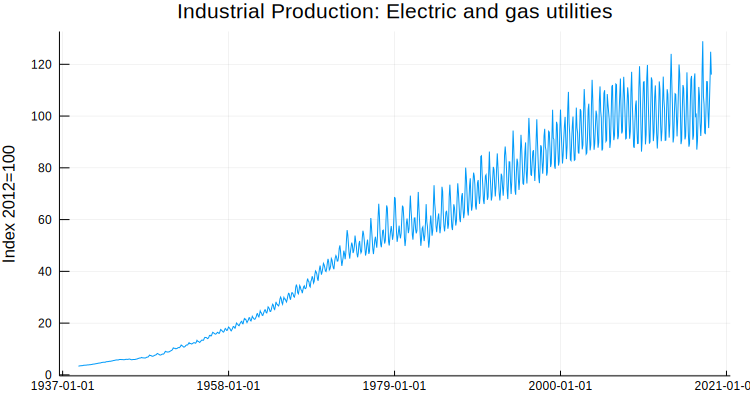

In [8]:
Plots.plot(obs_df[:date], obs_df[:value],
    size = [750, 400],
    title = "Industrial Production: Electric and gas utilities",
    ylabel = "Index 2012=100", 
    label = "")

全データを使うとフィッティングに時間がかかるので、2000年以降のデータを対象とする

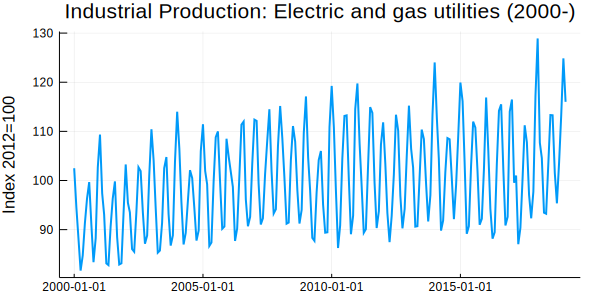

In [9]:
data_df = obs_df[obs_df[:date] .>= Date(2000,1,1), [:date, :value]]
Plots.plot(data_df[:date], data_df[:value],
    size = [600, 300],
    linewidth = 2,
    title = "Industrial Production: Electric and gas utilities (2000-)",
    ylabel = "Index 2012=100", 
    label = "")

## Local Level Model
\begin{align*}
y_t &= T_t + I_t, \\
T_{t+1} &= T_t + a_{T_i}, \\
I_t &\sim \text{Normal}(0, \sigma_I^2), \\
a_{T_i} &\sim \text{Normal}(0, \sigma_T^2)\\
T_0 &\sim \text{Normal}(T_{init}, 100^2) \\
\end{align*}

In [41]:
local_level_model = Model(
    
    obs = Stochastic(1,
        (T, sigma_I) -> MvNormal(T, sigma_I),
        false
    ),
    
    T = Logical(1,
        (T_0, disturbance) -> T_0 .+ vcat([0], cumsum(disturbance)),
    ),
    
    disturbance = Stochastic(1,
        (N, sigma_T) -> MvNormal(zeros(N - 1), sigma_T),
        false
    ),
    
    sigma_I = Stochastic(() -> InverseGamma()),
    sigma_T = Stochastic(() -> InverseGamma()),
    
    T_0 = Stochastic(T_init -> Normal(T_init, 100)),
)

Object of type "Model"
-------------------------------------------------------------------------------
T:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
sigma_T:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
sigma_I:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
T_0:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
disturbance:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


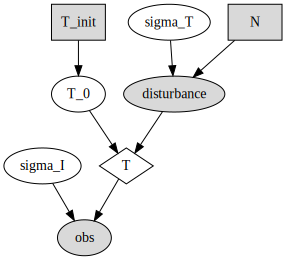

In [42]:
display("image/svg+xml", dot2svg(graph2dot(local_level_model)))

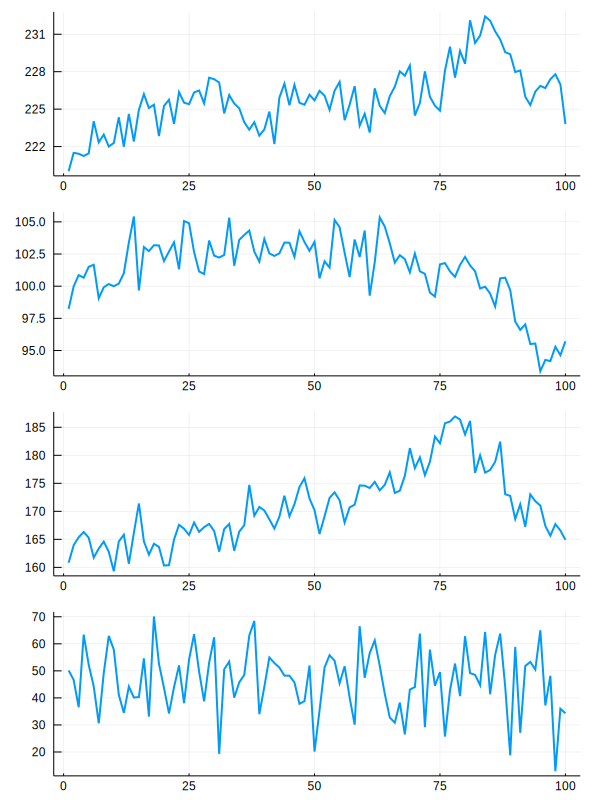

In [43]:
function sample_local_level_model()
    N = 100
    T_0 = rand(Normal(100, 100))
    sigma_I = rand(InverseGamma())
    sigma_T = rand(InverseGamma())
    disturbance = rand(MvNormal(zeros(N - 1), sigma_T))
    T = T_0 .+ vcat([0], cumsum(disturbance))
    obs = rand(MvNormal(T, sigma_I))
    
    Dict(
        :N => N,
        :T_0 => T_0,
        :sigma_I => sigma_I,
        :sigma_T => sigma_T,
        :disturbance => disturbance,
        :T => T,
        :obs => obs,
    )
end

plts = []
for i in 1:4
    sample = sample_local_level_model()
    push!(plts, Plots.plot(sample[:obs], linewidth = 2, label = ""))
end
Plots.plot(plts..., layout = (4, 1), size = [600, 800])

### サンプルに対してフィッティング

In [44]:
local_level_sample = sample_local_level_model()

Dict{Symbol,Any} with 7 entries:
  :T           => [176.724, 176.961, 174.697, 175.712, 175.8, 176.648, 177.221,…
  :N           => 100
  :sigma_I     => 0.330432
  :T_0         => 176.724
  :sigma_T     => 0.992428
  :obs         => [176.684, 177.082, 174.192, 175.745, 175.985, 177.424, 177.41…
  :disturbance => [0.236698, -2.26368, 1.01492, 0.0877885, 0.848665, 0.572865, …

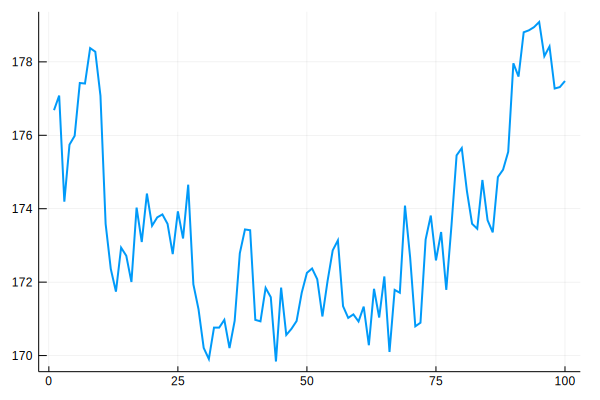

In [45]:
Plots.plot(local_level_sample[:obs], linewidth = 2, label = "")

In [46]:
local_level_sample_data = Dict(
    :obs => local_level_sample[:obs],
    :N => local_level_sample[:N],
    :T_init => local_level_sample[:obs][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 100
  :T_init => 176.684
  :obs    => [176.684, 177.082, 174.192, 175.745, 175.985, 177.424, 177.41, 178…

In [47]:
local_level_sample_inits = [
    Dict(
        :obs => local_level_sample[:obs],
        :T => local_level_sample[:obs],
        :disturbance => zeros(local_level_sample[:N] - 1),
        :sigma_I => 1,
        :sigma_T => 1,
        :T_0 => local_level_sample[:obs][1],
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[176.684, 177.082, 174.192, 175.745, 175.985, 177.424, 177.41, 178.375, 178.276, 177.075  …  177.599, 178.806, 178.859, 178.946, 179.086, 178.154, 178.419, 177.274, 177.313, 177.479],:sigma_T=>1,:sigma_I=>1,:T_0=>176.684,:obs=>[176.684, 177.082, 174.192, 175.745, 175.985, 177.424, 177.41, 178.375, 178.276, 177.075  …  177.599, 178.806, 178.859, 178.946, 179.086, 178.154, 178.419, 177.274, 177.313, 177.479],:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Dict(:T=>[176.684, 177.082, 174.192, 175.745, 175.985, 177.424, 177.41, 178.375, 178.276, 177.075  …  177.599, 178.806, 178.859, 178.946, 179.086, 178.154, 178.419, 177.274, 177.313, 177.479],:sigma_T=>1,:sigma_I=>1,:T_0=>176.684,:obs=>[176.684, 177.082, 174.192, 175.745, 175.985, 177.424, 177.41, 178.375, 178.276, 177.075  …  177.599, 178.806, 178.859, 178.946, 179.086, 178.154, 178.419, 177.274, 177.313, 177.479],:dis

In [48]:
local_level_scheme = [
    AMWG([:disturbance], 1.0), Slice([:sigma_I, :sigma_T, :T_0], 1.0)
]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:disturbance]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Multivariate}}"
Sampling Block Nodes:
Symbol[:sigma_I, :sigma_T, :T_0]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                          

In [49]:
setsamplers!(local_level_model, local_level_scheme)
local_level_sample_sim = mcmc(
    local_level_model, local_level_sample_data, local_level_sample_inits, 
    35000, burnin = 5000, thin = 10, chains = 3)

MCMC Simulation of 35000 Iterations x 3 Chains...

      From worker 3:	Chain 1:   0% [0:04:52 of 0:04:52 remaining]
      From worker 4:	Chain 2:   0% [0:04:48 of 0:04:48 remaining]
      From worker 2:	Chain 3:   0% [0:03:56 of 0:03:56 remaining]
      From worker 4:	Chain 2:  10% [0:01:19 of 0:01:27 remaining]
      From worker 3:	Chain 1:  10% [0:01:21 of 0:01:30 remaining]
      From worker 2:	Chain 3:  10% [0:01:21 of 0:01:30 remaining]
      From worker 4:	Chain 2:  20% [0:01:09 of 0:01:26 remaining]
      From worker 2:	Chain 3:  20% [0:01:10 of 0:01:27 remaining]
      From worker 3:	Chain 1:  20% [0:01:10 of 0:01:28 remaining]
      From worker 4:	Chain 2:  30% [0:01:03 of 0:01:29 remaining]
      From worker 2:	Chain 3:  30% [0:01:03 of 0:01:30 remaining]
      From worker 3:	Chain 1:  30% [0:01:03 of 0:01:30 remaining]
      From worker 4:	Chain 2:  40% [0:00:54 of 0:01:29 remaining]
      From worker 2:	Chain 3:  40% [0:00:54 of 0:01:30 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 5010:35000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[0.629266 0.918736 … 177.061 176.343; 0.53349 0.873471 … 177.351 178.062; … ; 0.701623 0.828956 … 177.481 177.123; 0.547208 0.851215 … 177.139 177.495]

[0.916391 0.625612 … 177.668 177.882; 0.998304 0.683948 … 177.951 178.012; … ; 0.255445 1.21428 … 177.539 177.606; 0.265001 1.11953 … 177.413 177.248]

[0.49899 0.908235 … 177.543 176.67; 0.555644 1.01173 … 178.684 177.704; … ; 0.530999 1.0176 … 177.045 176.839; 0.54063 1.15609 … 177.224 177.298]

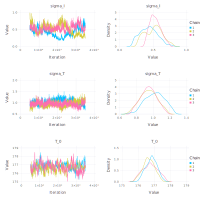

In [50]:
p = Mamba.plot(local_level_sample_sim[:, [:sigma_I, :sigma_T, :T_0], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

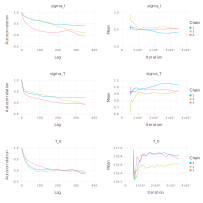

In [51]:
p = Mamba.plot(local_level_sample_sim[:, [:sigma_I, :sigma_T, :T_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

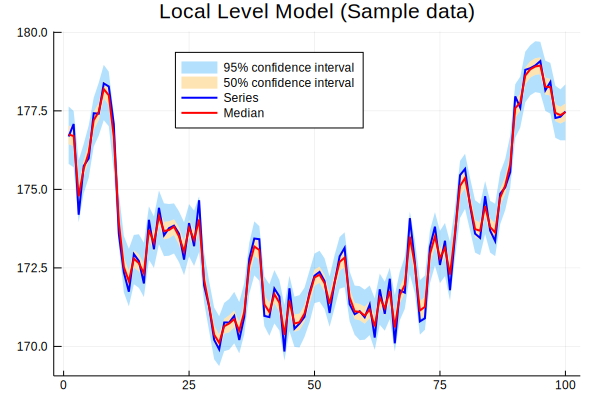

In [54]:
Ts = quantile(local_level_sample_sim[:, [:T], :]).value
Plots.plot(Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(local_level_sample[:obs],
    linewidth = 2, linecolor = :blue,
    title = "Local Level Model (Sample data)",
    label = "Series")
Plots.plot!(Ts[:, 3, :], 
    legend = :top,
    linewidth = 2, linecolor = :red, label = "Median")

### FREDから取得したデータに対してフィッティング

In [58]:
local_level_fred_data = Dict(
    :obs => data_df[:value],
    :N => size(data_df, 1),
    :T_init => data_df[:value][1],
)

Dict{Symbol,Any} with 3 entries:
  :N      => 230
  :T_init => 102.497
  :obs    => [102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99…

In [61]:
local_level_fred_inits = [
    Dict(
        :obs => data_df[:value],
        :T => data_df[:value],
        :disturbance => zeros(size(data_df, 1) - 1),
        :sigma_I => 1,
        :sigma_T => 1,
        :T_0 => data_df[:value][1],
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:sigma_T=>1,:sigma_I=>1,:T_0=>102.497,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:disturbance=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Dict(:T=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:sigma_T=>1,:sigma_I=>1,:T_0=>102.497,:obs=>[102.497, 94.5218, 88.3463, 81.6662, 84.7235, 91.3293, 96.3011, 99.6734, 90.9515, 83.378  …  93.2405, 103.308, 113.318, 113.276, 101.566, 95.3546, 103.645, 113.244, 124.858, 116.011],:dis

In [62]:
local_level_fred_sim = mcmc(
    local_level_model, local_level_fred_data, local_level_fred_inits, 
    25000, burnin = 5000, thin = 10, chains = 3)

MCMC Simulation of 25000 Iterations x 3 Chains...

      From worker 3:	Chain 3:   0% [0:11:04 of 0:11:04 remaining]
      From worker 4:	Chain 2:   0% [0:21:12 of 0:21:13 remaining]
      From worker 2:	Chain 1:   0% [0:27:10 of 0:27:11 remaining]
      From worker 3:	Chain 3:  10% [0:01:60 of 0:02:13 remaining]
      From worker 2:	Chain 1:  10% [0:01:59 of 0:02:12 remaining]
      From worker 4:	Chain 2:  10% [0:02:02 of 0:02:16 remaining]
      From worker 2:	Chain 1:  20% [0:01:43 of 0:02:09 remaining]
      From worker 3:	Chain 3:  20% [0:01:45 of 0:02:12 remaining]
      From worker 4:	Chain 2:  20% [0:01:46 of 0:02:13 remaining]
      From worker 2:	Chain 1:  30% [0:01:34 of 0:02:15 remaining]
      From worker 3:	Chain 3:  30% [0:01:37 of 0:02:18 remaining]
      From worker 4:	Chain 2:  30% [0:01:38 of 0:02:19 remaining]
      From worker 2:	Chain 1:  40% [0:01:20 of 0:02:13 remaining]
      From worker 3:	Chain 3:  40% [0:01:22 of 0:02:17 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 5010:25000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[9.43212 0.448006 … 103.614 103.565; 9.68703 0.476556 … 101.948 102.444; … ; 8.87849 0.425747 … 99.801 98.9209; 9.03131 0.492757 … 105.75 106.472]

[9.69718 0.327177 … 103.151 103.657; 9.48861 0.292408 … 103.663 103.407; … ; 8.60342 0.584852 … 105.764 106.054; 8.74759 0.47385 … 101.89 101.221]

[9.46897 0.661423 … 107.133 108.064; 8.71344 0.654456 … 109.055 108.073; … ; 8.66842 0.686694 … 104.598 103.839; 9.1573 0.581936 … 104.631 104.373]

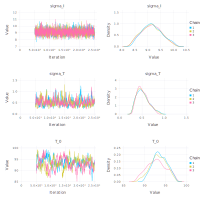

In [65]:
p = Mamba.plot(local_level_fred_sim[:, [:sigma_I, :sigma_T, :T_0], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

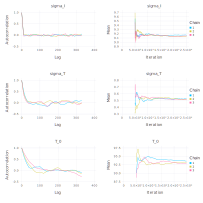

In [66]:
p = Mamba.plot(local_level_fred_sim[:, [:sigma_I, :sigma_T, :T_0], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

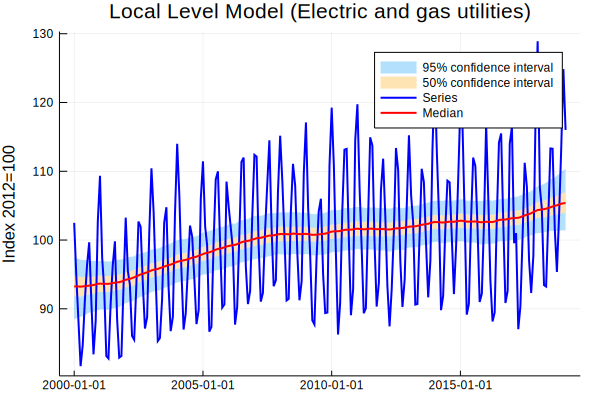

In [67]:
Ts = quantile(local_level_fred_sim[:, [:T], :]).value
Plots.plot(data_df[:date], Ts[:, 1, :], 
    fillrange = Ts[:, 5, :], fillalpha = 0.3,
    linewidth = 0, label = "95% confidence interval")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 1, fillcolor = :white,
    linewidth = 0, label = "")
Plots.plot!(data_df[:date], Ts[:, 2, :], 
    fillrange = Ts[:, 4, :], fillalpha = 0.3, fillcolor = :orange,
    linewidth = 0, label = "50% confidence interval")
Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :blue,
    title = "Local Level Model (Electric and gas utilities)",
    ylabel = "Index 2012=100", 
    label = "Series")
Plots.plot!(data_df[:date], Ts[:, 3, :], 
    linewidth = 2, linecolor = :red, label = "Median")

## Local Linear Model

In [ ]:
local_linear_model = Model(
    
    obs = Stochastic(1,
        (T, beta, sigma_I) -> MvNormal(T + beta, sqrt(sigma_I)),
        false
    ),
    
    T = Logical(1,
        (alpha, disturbance) -> alpha .+ cumsum(disturbance),
    ),
    
    disturbance = Stochastic(1,
        (N, sigma_T) -> MvNormal(zeros(N), sqrt(sigma_T)),
        false
    ),
    
    beta = Logical(1,
        (b, zeta) -> b .+ cumsum(zeta),
    ),
    
    zeta = Stochastic(1,
        (N, sigma_zeta) -> MvNormal(zeros(N), sqrt(sigma_zeta)),
        false
    ),    
    
    sigma_I = Stochastic(() -> InverseGamma()),
    sigma_T = Stochastic(() -> InverseGamma()),
    sigma_zeta = Stochastic(() -> InverseGamma()),
)

In [ ]:
display("image/svg+xml", dot2svg(graph2dot(local_linear_model)))

In [ ]:
function sample_local_linear_model()
    N = 100
    alpha = rand(Truncated(Normal(100, 10), 0, Inf))
    b = rand(Uniform(-10, 10))
    sigma_I = rand(InverseGamma())
    sigma_T = rand(InverseGamma())
    sigma_zeta = rand(InverseGamma())
    disturbance = rand(MvNormal(zeros(N), sigma_T))
    zeta = rand(MvNormal(zeros(N), sigma_zeta))
    T = alpha .+ cumsum(disturbance)
    beta = b .+ cumsum(zeta)
    obs = rand(MvNormal(T + beta, sigma_I))
    
    Dict(
        :N => N,
        :alpha => alpha,
        :b => b,
        :sigma_I => sigma_I,
        :sigma_T => sigma_T,
        :sigma_zeta => sigma_zeta,
        :disturbance => disturbance,
        :zeta => zeta,
        :T => T,
        :beta => beta,
        :obs => obs,
    )
end

plts = []
for i in 1:4
    sample = sample_local_linear_model()
    push!(plts, Plots.plot(sample[:obs], linewidth = 2, label = ""))
end
Plots.plot(plts..., layout = (4, 1), size = [600, 800])

In [ ]:
local_liner_fred_data = Dict(
    :obs => data_df[:value],
    :N => size(data_df, 1),
    :alpha => data_df[:value][1],
)

In [ ]:
local_linear_fred_inits = [
    Dict(
        :obs => data_df[:value],
        :T => data_df[:value],
        :disturbance => zeros(size(data_df, 1)),
        :sigma_I => 1,
        :sigma_T => 1,
        :sigma_zeta => 1,
    ) for _ in 1:3
]